In [3]:
import numpy as np
import pandas as pd

item_categories = pd.read_csv('data\item_categories.csv')
items = pd.read_csv('data\items.csv')
sales = pd.read_csv('data\sales_train.csv')
shops = pd.read_csv('data\shops.csv')

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Data Preparation
<b>1. Do Basic EDA and remove outliers

In [5]:
sales = sales[sales['item_price']<100000]
sales = sales[sales['item_cnt_day']<=1000]

__2. Group data at a level you want your predictions to be:__
<br>We start with creating a dataframe of distinct date_block_num, store and item combinations.
This is important because in the months we don’t have a data for an item store combination, the machine learning algorithm needs to be told explicitly that the sales are zero.

In [6]:
from itertools import product
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


The grid dataFrame contains all the shop, items and month combinations.
We then merge the Grid with Sales to get the monthly sales DataFrame. We also replace all the NA’s with zero for months that didn’t have any sales.

In [7]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

# Merging sales numbers with the grid dataframe
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

# adding the category id too from the items table.
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')

In [8]:
sales_m.sample(5)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
7639383,55,21760,21,0.0,0.0,ЧУЖОЙ. АНТОЛОГИЯ (2014),41
1712744,52,17681,4,0.0,0.0,Порхающие маленькие наклейки бабочки 10,66
2258958,52,17060,5,0.0,0.0,ПИРАНЬИ 3D (регион),40
10730443,37,14396,33,0.0,0.0,МАТРИЦА WB (BD),37
4128591,24,1216,11,0.0,0.0,AC/DC If You Want Blood You'Ve Got It,55


<b>3. Create Target Encodings

To create target encodings, we group by a particular column and take the mean/min/sum etc. of the target column on it. These features are the first features we create in our model.

In [9]:
groupcollist = ['item_id','shop_id','item_category_id']

aggregationlist = [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = sales_m.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        # merge new columns on sales_m data
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num',type_id],how='left')

In [10]:
sales_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.800000,18.0,0.400000,97.974472,2017.0,0.248552,63.014719,6094.0,0.199738
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977778,0.0,0.000000,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,97.974472,2017.0,0.248552,54.898665,287.0,0.043386
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837778,2.0,0.044444,97.974472,2017.0,0.248552,38.267019,268.0,0.049630
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400000,5.0,0.111111,97.974472,2017.0,0.248552,35.593867,701.0,0.093280


<b>4. Create Lag Features

When we create regular classification models, we treat training examples as fairly independent of each other. But in case of time series problems, at any point in time, the model needs information on what happened in the past. Lag will be added to all new features we created

In [11]:
lag_variables  = ['item_id_avg_item_price','item_id_sum_item_cnt_day','item_id_avg_item_cnt_day',
                  'shop_id_avg_item_price','shop_id_sum_item_cnt_day','shop_id_avg_item_cnt_day',
                  'item_category_id_avg_item_price','item_category_id_sum_item_cnt_day',
                  'item_category_id_avg_item_cnt_day','item_cnt_day']
lags = [1 ,2 ,3 ,4, 5, 12]
# we will keep the results in this dataframe
sales_means = sales_m.copy()
for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    # subset only the lag variables we want
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    # join with date_block_num,shop_id and item_id
    sales_means = pd.merge(sales_means, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [12]:
sales_means.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,310.800000,18.0,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,19.977778,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,37.978889,1.0,0.022222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,48.837778,2.0,0.044444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,36.400000,5.0,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#We fill the NA’s with zeros once we have the lag features.

for feat in sales_means.columns:
    if 'item_cnt' in feat:
        sales_means[feat]=sales_means[feat].fillna(0)
    elif 'item_price' in feat:
        sales_means[feat]=sales_means[feat].fillna(sales_means[feat].median())

## Modelling
<b>1. Drop the unrequired columns

In [15]:
cols_to_drop = lag_variables[:-1] + ['item_name','item_price']

for col in cols_to_drop:
    del sales_means[col]

In [16]:
cols_to_drop 

['item_id_avg_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_avg_item_cnt_day',
 'shop_id_avg_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_avg_item_cnt_day',
 'item_category_id_avg_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_avg_item_cnt_day',
 'item_name',
 'item_price']

__2. Take a recent bit of data only__
<br>When we created the lag variables, we induced a lot of zeroes in the system. We used the maximum lag as 12. To counter that we remove the first 12 months indexes.

In [18]:
sales_means = sales_means[sales_means['date_block_num']>11]

__3. Train and CV Split__

In [22]:
X_train = sales_means[sales_means['date_block_num']<33]
X_cv =  sales_means[sales_means['date_block_num']==33]
Y_train = X_train['item_cnt_day']
Y_cv = X_cv['item_cnt_day']
del X_train['item_cnt_day']
del X_cv['item_cnt_day']

__4. Create a Baseline Score__
<br> Before we proceed with modelling steps, lets check the RMSE of a naive model, as we want to have an RMSE to compare to. We assume that we are going to predict the last month sales as current month sale for our baseline model. We can quantify the performance of our model using this baseline RMSE.

In [19]:
from sklearn.metrics import mean_squared_error
sales_m_test = sales_m[sales_m['date_block_num']==33]

preds = sales_m.copy()
preds['date_block_num']=preds['date_block_num']+1
preds = preds[preds['date_block_num']==33]
preds = preds.rename(columns={'item_cnt_day':'preds_item_cnt_day'})
preds = pd.merge(sales_m_test,preds,on = ['shop_id','item_id'],how='left')[['shop_id','item_id','preds_item_cnt_day','item_cnt_day']].fillna(0)

# We want our predictions clipped at (0,20). Competition Specific
preds['item_cnt_day'] = preds['item_cnt_day'].clip(0,20)
preds['preds_item_cnt_day'] = preds['preds_item_cnt_day'].clip(0,20)
baseline_rmse = np.sqrt(mean_squared_error(preds['item_cnt_day'],preds['preds_item_cnt_day']))

print(baseline_rmse)

1.1358170090812756


__5. Train XGB__

In [24]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8,
    tree_method='exact',  #this makes training slower but more accurate
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_cv, Y_cv)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:3.18591	validation_1-rmse:2.40136
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.00237	validation_1-rmse:2.22795
[2]	validation_0-rmse:2.87864	validation_1-rmse:2.12529
[3]	validation_0-rmse:2.79387	validation_1-rmse:2.06186
[4]	validation_0-rmse:2.74259	validation_1-rmse:2.02639
[5]	validation_0-rmse:2.70935	validation_1-rmse:2.00291
[6]	validation_0-rmse:2.68411	validation_1-rmse:1.98310
[7]	validation_0-rmse:2.67269	validation_1-rmse:1.97480
[8]	validation_0-rmse:2.66320	validation_1-rmse:1.96917
[9]	validation_0-rmse:2.65281	validation_1-rmse:1.96345
[10]	validation_0-rmse:2.64575	validation_1-rmse:1.96326
[11]	validation_0-rmse:2.64166	validation_1-rmse:1.96519
[12]	validation_0-rmse:2.63821	validation_1-rmse:1.96710
[13]	validation_0-rmse:2.63293	validation_1-rmse:1.96397
[14]	validation_0-rmse:2.62602	validation_1-rmse:1.96

KeyError: 'base_score'

KeyError: 'base_score'

__6. Plot Feature Importance__

<AxesSubplot:xlabel='col'>

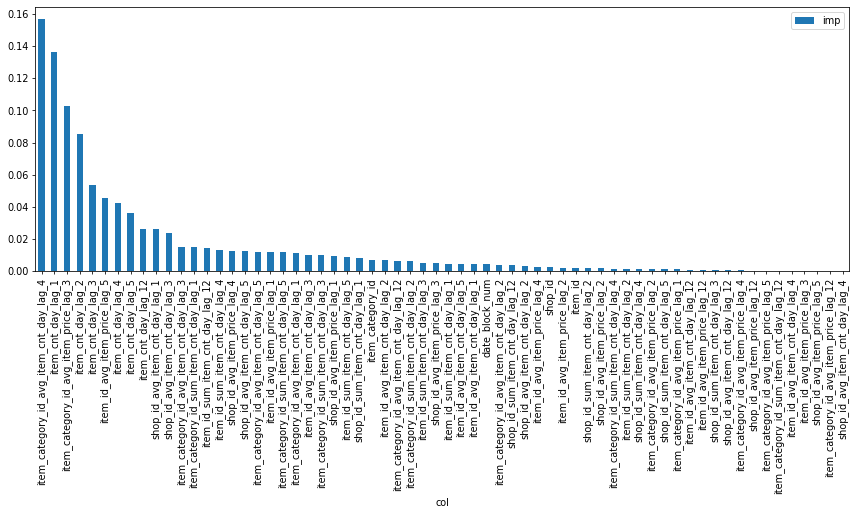

In [37]:
import matplotlib.pyplot as plt
feature_importances = pd.DataFrame({'col': X_train.columns,'imp':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='imp',ascending=False)
#px.bar(feature_importances,x='col',y='imp')
ax = plt.figure(figsize=(15,5),dpi=70).add_subplot()
feature_importances.plot(kind='bar',x='col',y='imp',ax=ax)